In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [22]:
#Importing Data

df = pd.read_csv('../data/processed/selected_features.csv',index_col=[0])
to_drop = ['Gini index','Country Name','Year']
X = df.drop(to_drop,axis=1).to_numpy() 

y = df['Gini index'].to_numpy()
groups = df['Country Name'].to_numpy()


#preprocessing pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

preprocess_steps = [('scaler',StandardScaler()),
                    ('ct',ColumnTransformer([('pca',PCA(n_components=2),list(range(5,11)))],remainder='passthrough'))]


#Setting up cross-validation
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=5)

#Setting up model
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

params = {'reg_lambda': 1.2000000000000002,
 'reg_alpha': 0.2,
 'n_estimators': 115,
 'max_depth': 2,
 'learning_rate': 0.4}

model = Pipeline(steps=preprocess_steps + [('xgb',XGBRegressor(**params))])


#Feature Names
columns = df.drop(to_drop,axis=1).columns.to_list()
feature_names = [col for col in columns if col.find('Poverty') < 0]

feature_names = ['poverty_pca0','poverty_pca1'] + feature_names

In [23]:
df.head()

,Year,"Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative)","Cause of death, by injury (% of total)","Educational attainment, at least completed short-cycle tertiary, population 25+, total (%) (cumulative)","Population, total","Hospital beds (per 1,000 people)",Country Name,Gini index,Poverty headcount ratio at $3.65 a day (2017 PPP) (% of population),Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population),Poverty gap at $2.15 a day (2017 PPP) (%),Poverty gap at $3.65 a day (2017 PPP) (%),Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population),Poverty gap at $6.85 a day (2017 PPP) (%),GDP per capita
11420,2002,88.543221,8.507397,38.141708,48202470.0,8.89,Ukraine,29.0,17.0,61.9,0.5,3.7,2.7,20.8,911.906871
11686,2003,88.543221,8.507397,38.141708,47812949.0,8.81,Ukraine,28.7,10.4,54.1,0.2,2.1,1.1,16.0,1087.788007
12624,2007,95.692841,10.150055,17.622650,5268400.0,5.06,Kyrgyz Republic,33.9,33.6,74.2,1.7,9.5,8.8,31.8,721.769526
12687,2007,61.490292,12.359977,21.358910,3431614.0,2.30,Panama,52.7,14.9,30.5,2.2,5.7,6.7,13.6,6205.821576
12879,2008,80.522840,5.055017,30.182824,4489544.0,4.85,Ireland,30.9,0.3,0.8,0.1,0.2,0.2,0.4,61353.106563


In [24]:
from sklearn.model_selection import cross_val_score


scores = cross_val_score(model,X,y,groups=groups,cv=gkf)
print(scores)
print(np.average(scores))

[0.62558924 0.58994853 0.90792778 0.50466162 0.70102424]
0.6658302839695536


In [25]:
folds = gkf.split(X,y,groups=groups)
feature_importances = {}
for f in feature_names:
    feature_importances[f] = []

for i in range(5):
    train_ind, test_ind = next(folds)
    X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[test_ind], y[test_ind]

    model.fit(X_train,y_train)
    fold_fi = model.named_steps['xgb'].feature_importances_
    
    for j in range(len(feature_names)):
        feature_importances[feature_names[j]].append(fold_fi[j])

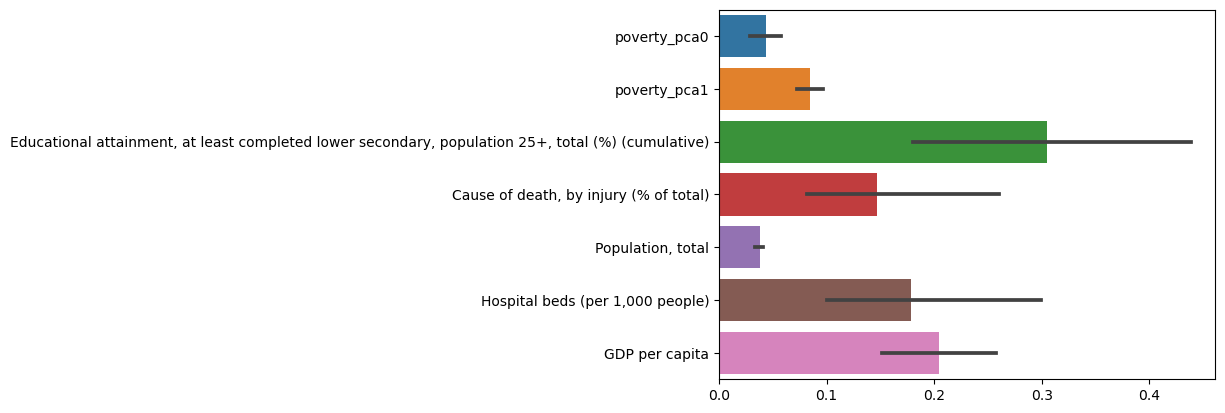

In [26]:
sns.barplot(pd.DataFrame(feature_importances),orient='h');

In [27]:
from sklearn.inspection import permutation_importance

folds = gkf.split(X,y,groups=groups)
permutation_importances = {}
for f in feature_names:
    permutation_importances[f] = []

for i in range(5):
    train_ind, test_ind = next(folds)
    X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[test_ind], y[test_ind]

    preprocessor = Pipeline(steps=preprocess_steps)
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    xgb = XGBRegressor(**params)
    xgb.fit(X_train,y_train)
    perm = permutation_importance(xgb,X_test, y_test, random_state=1)
    fold_pi = perm.importances_mean # type: ignore
    for j in range(len(feature_names)):
        permutation_importances[feature_names[j]].append(fold_pi[j])

<Axes: >

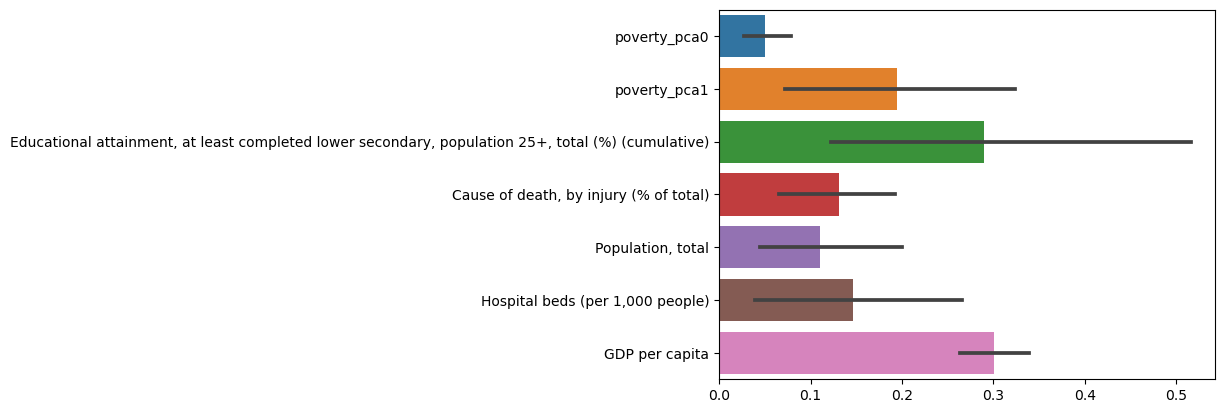

In [28]:
sns.barplot(pd.DataFrame(permutation_importances),orient='h')

In [29]:
import warnings    #avoiding a few annoying sklearn warnings, feel free to skip this cell

def warn(*args,**kwargs):
    pass

warnings.warn = warn

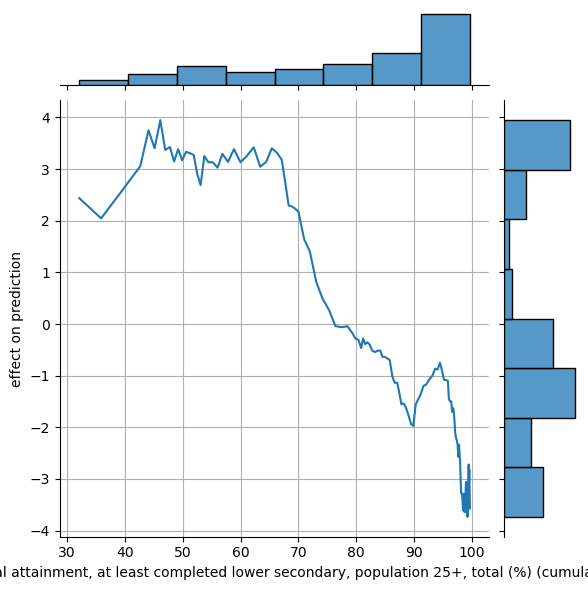

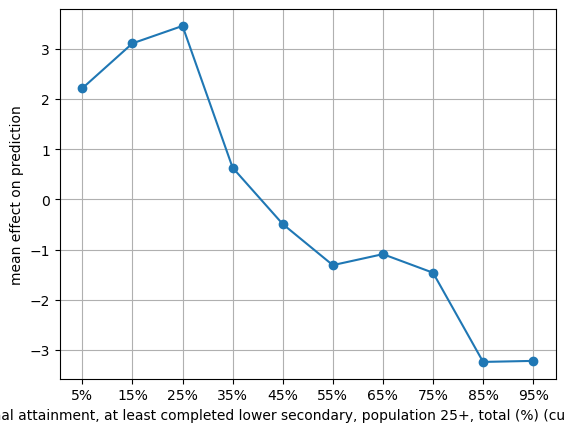

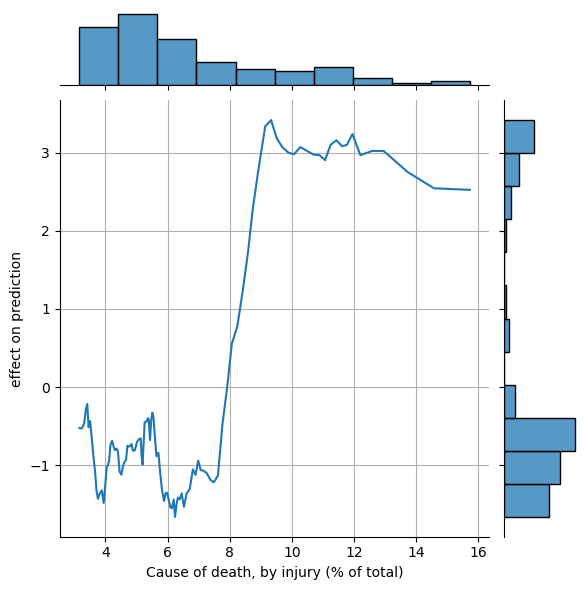

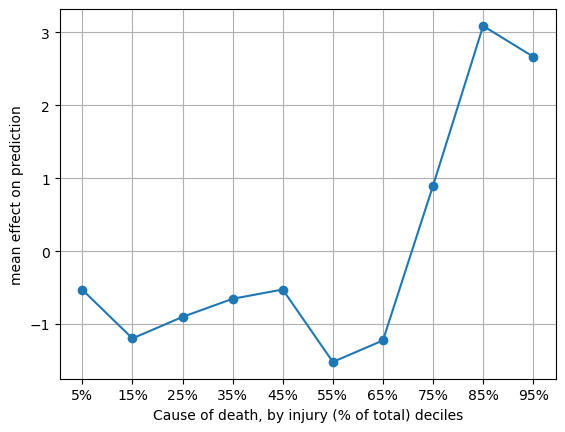

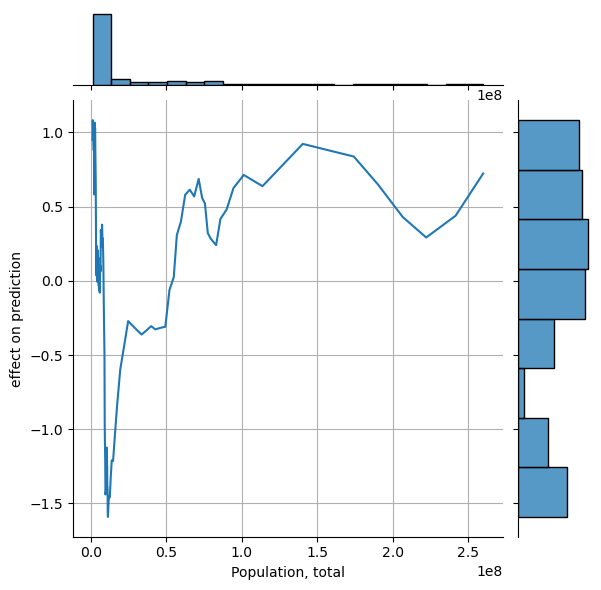

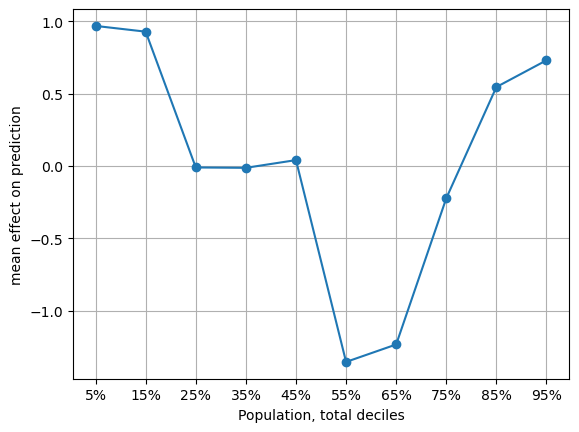

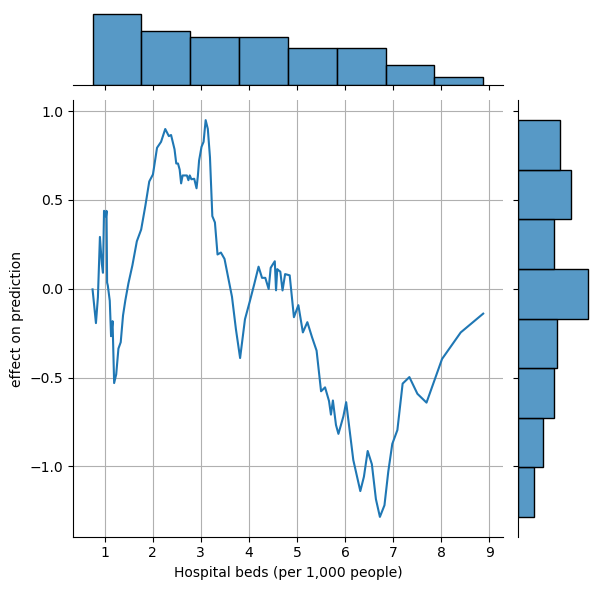

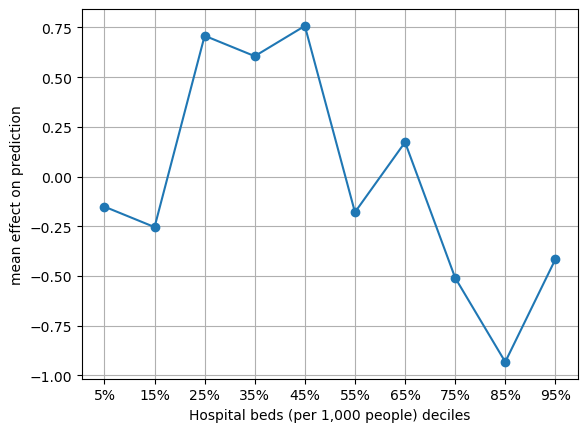

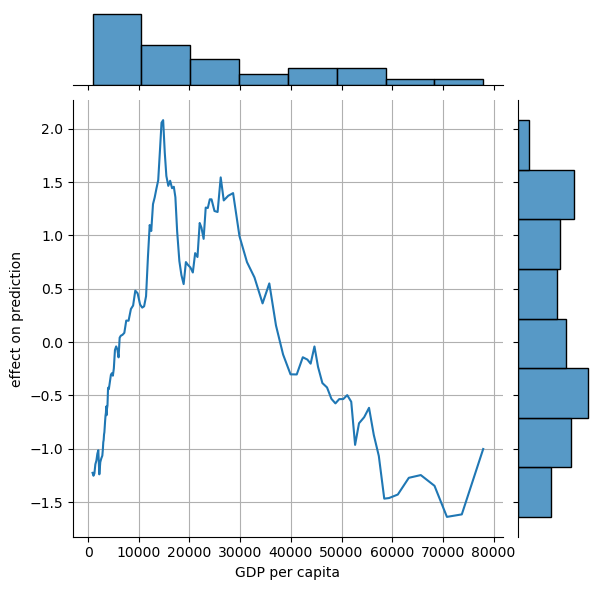

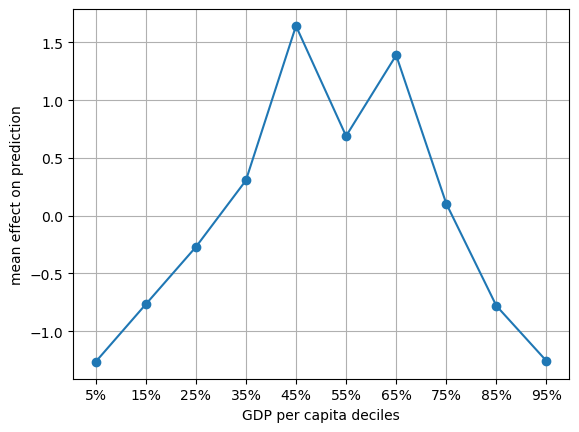

In [30]:
from PyALE import ale

for f in feature_names:
    if f.find('poverty') == -1:
        ale_eff = pd.DataFrame([[1]])
        folds = gkf.split(X,y,groups=groups)

        for i in range(5):
            train_ind, test_ind = next(folds)
            X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[test_ind], y[test_ind]
            model.fit(X_train,y_train)

            co = df.drop(to_drop,axis=1).columns
            if len(ale_eff) == 1:
                ale_eff = ale(pd.DataFrame(X_test,columns=co),model,[f],grid_size=50,plot=False,feature_type='continuous')
            else: ale_eff = pd.concat([ale_eff,ale(pd.DataFrame(X_test,columns=co),model,[f],plot=False,feature_type='continuous')])
        
        ale_eff = ale_eff.sort_index()
        ale_eff[f] = ale_eff.index
        roll_ale = ale_eff.rolling(10).mean()
        roll_ale = roll_ale[~roll_ale.index.duplicated()]

        g = sns.JointGrid(data=roll_ale, x=f, y="eff")
        g.ax_joint.grid(True)
        g.ax_joint.set_ylabel('effect on prediction')
        g.plot(sns.lineplot, sns.histplot)
        plt.show();

        xdeciles = np.percentile(ale_eff[f], np.arange(5, 100, 10))
        ydeciles = []
        
        for i in range(1,11):
            minp = i*10 - 10
            maxp = i*10
            min_x = np.percentile(ale_eff[f],minp) 
            max_x = np.percentile(ale_eff[f],maxp)
            ydeciles.append(ale_eff[(ale_eff[f] < max_x) & (ale_eff[f] > min_x)]['eff'].mean())
        
        plt.plot(np.arange(5, 100, 10),ydeciles,marker='o', linestyle='-')
        plt.xticks(np.arange(5, 100, 10), [f'{i}%' for i in np.arange(5, 100, 10)])
        plt.grid(True)
        plt.xlabel(f + ' deciles')
        plt.ylabel('mean effect on prediction')
        plt.show()
        
        

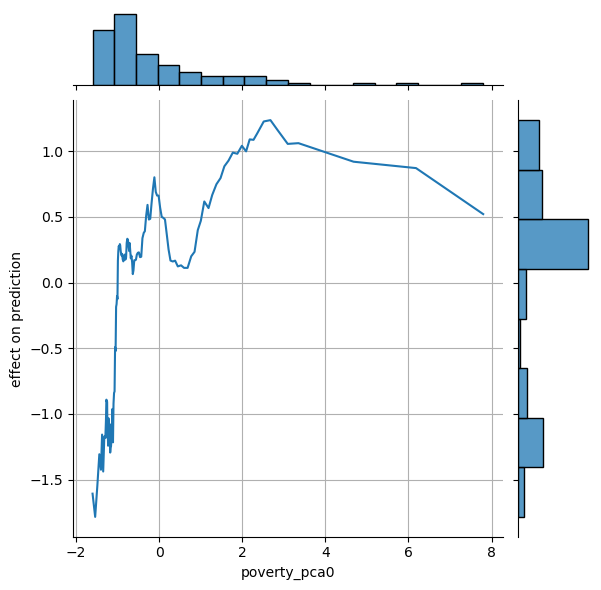

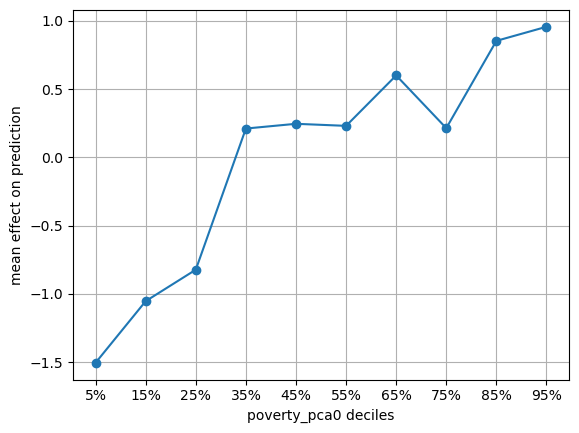

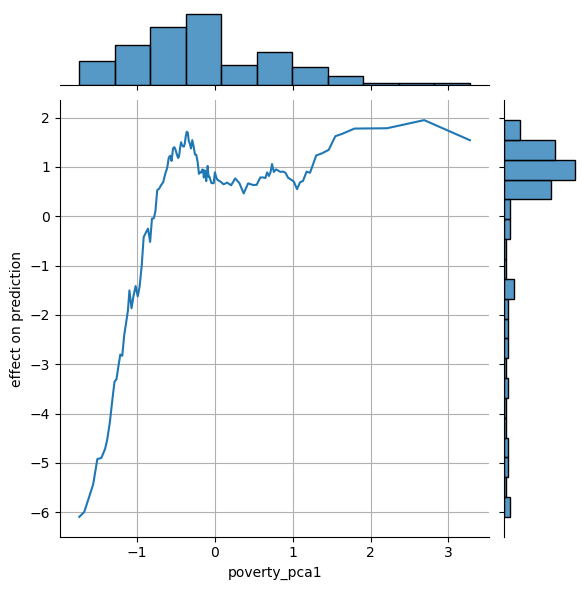

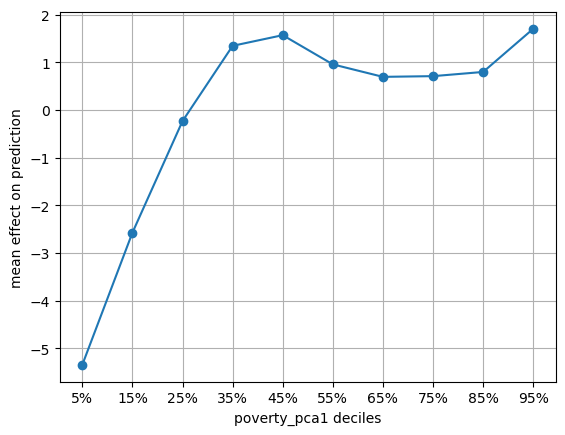

In [31]:
from PyALE import ale


for f in ['poverty_pca0','poverty_pca1']:
    ale_eff = pd.DataFrame([[1]])
    folds = gkf.split(X,y,groups=groups)

    for i in range(5):
        train_ind, test_ind = next(folds)
        X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[test_ind], y[test_ind]

        preprocessor = Pipeline(steps=preprocess_steps)
        X_train = preprocessor.fit_transform(X_train)
        X_test = preprocessor.transform(X_test)
        xgb = XGBRegressor(**params)
        xgb.fit(X_train,y_train)

        if len(ale_eff) == 1:
            ale_eff = ale(pd.DataFrame(X_test,columns=feature_names),xgb,[f],grid_size=50,plot=False,feature_type='continuous')
        else: ale_eff = pd.concat([ale_eff,ale(pd.DataFrame(X_test,columns=feature_names),xgb,[f],plot=False,feature_type='continuous')])


    
    ale_eff = ale_eff.sort_index()
    ale_eff[f] = ale_eff.index
    roll_ale = ale_eff.rolling(10).mean()
    roll_ale = roll_ale[~roll_ale.index.duplicated()]

    g = sns.JointGrid(data=roll_ale, x=f, y="eff")
    g.ax_joint.grid(True)
    g.ax_joint.set_ylabel('effect on prediction')
    g.plot(sns.lineplot, sns.histplot)
    plt.show();

    xdeciles = np.percentile(ale_eff[f], np.arange(5, 100, 10))
    ydeciles = []

    for i in range(1,11):
        minp = i*10 - 10
        maxp = i*10
        min_x = np.percentile(ale_eff[f],minp) 
        max_x = np.percentile(ale_eff[f],maxp)
        ydeciles.append(ale_eff[(ale_eff[f] < max_x) & (ale_eff[f] > min_x)]['eff'].mean())

    plt.plot(np.arange(5, 100, 10),ydeciles,marker='o', linestyle='-')
    plt.xticks(np.arange(5, 100, 10), [f'{i}%' for i in np.arange(5, 100, 10)])
    plt.grid(True)
    plt.xlabel(f + ' deciles')
    plt.ylabel('mean effect on prediction')
    plt.show()

In [32]:
df.head()

,Year,"Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative)","Cause of death, by injury (% of total)","Educational attainment, at least completed short-cycle tertiary, population 25+, total (%) (cumulative)","Population, total","Hospital beds (per 1,000 people)",Country Name,Gini index,Poverty headcount ratio at $3.65 a day (2017 PPP) (% of population),Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population),Poverty gap at $2.15 a day (2017 PPP) (%),Poverty gap at $3.65 a day (2017 PPP) (%),Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population),Poverty gap at $6.85 a day (2017 PPP) (%),GDP per capita
11420,2002,88.543221,8.507397,38.141708,48202470.0,8.89,Ukraine,29.0,17.0,61.9,0.5,3.7,2.7,20.8,911.906871
11686,2003,88.543221,8.507397,38.141708,47812949.0,8.81,Ukraine,28.7,10.4,54.1,0.2,2.1,1.1,16.0,1087.788007
12624,2007,95.692841,10.150055,17.622650,5268400.0,5.06,Kyrgyz Republic,33.9,33.6,74.2,1.7,9.5,8.8,31.8,721.769526
12687,2007,61.490292,12.359977,21.358910,3431614.0,2.30,Panama,52.7,14.9,30.5,2.2,5.7,6.7,13.6,6205.821576
12879,2008,80.522840,5.055017,30.182824,4489544.0,4.85,Ireland,30.9,0.3,0.8,0.1,0.2,0.2,0.4,61353.106563


In [36]:
from sklearn.calibration import cross_val_predict
from sklearn.metrics import r2_score

df['predicted Gini index'] = cross_val_predict(model,X,y,groups=groups,cv=gkf)
df['Residuals'] = df['predicted Gini index'] - df['Gini index']

r2_score(df['Gini index'],df['predicted Gini index'])

0.7133611140526254

In [44]:
by_country_count = df[['Country Name','Year']].groupby(by='Country Name').agg('count')

by_country_count

,Year
Country Name,
Albania,3
Australia,3
Austria,7
Bangladesh,2
Belarus,2
...,...
United Arab Emirates,2
United Kingdom,11
United States,6


In [58]:
by_country = df[['Country Name','Residuals','Gini index','predicted Gini index']].groupby(by='Country Name').agg('mean')

by_country['Sample Size (Years)'] = df[['Country Name','Year']].groupby(by='Country Name').agg('count')
by_country.head()
by_country['Country Name'] = by_country.index

<Axes: xlabel='Gini index', ylabel='Country Name'>

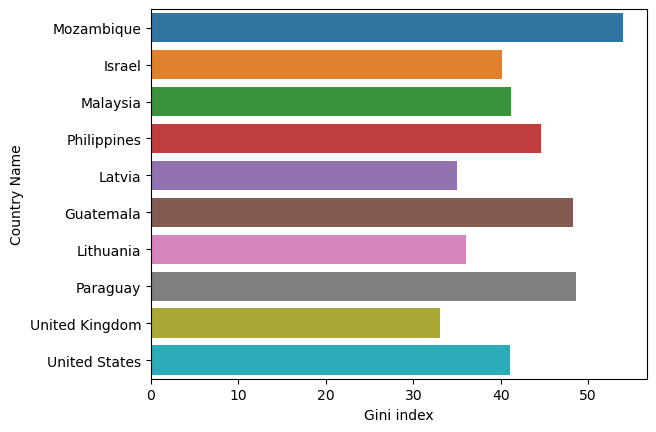

In [67]:
sns.barplot(by_country.nsmallest(10,'Residuals'),x='Gini index',y='Country Name',orient='h')

<Axes: xlabel='Gini index', ylabel='Country Name'>

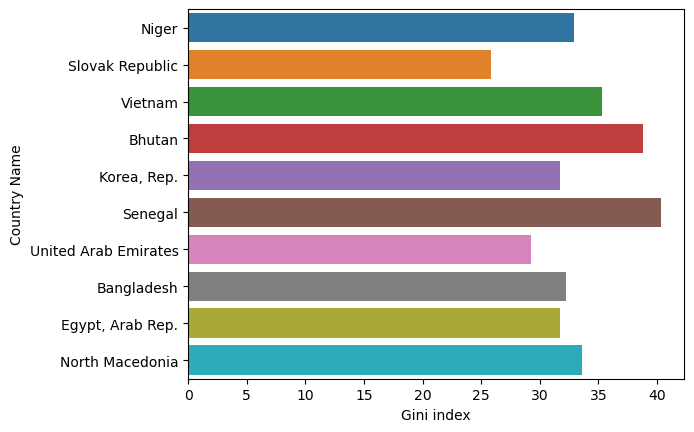

In [68]:
sns.barplot(by_country.nlargest(10,'Residuals'),x='Gini index',y='Country Name',orient='h')

In [47]:
by_country['Residuals'].nlargest(10) #shapley values

Country Name
Niger                   15.759580
Slovak Republic          8.780694
Vietnam                  8.154708
Bhutan                   7.957511
Korea, Rep.              7.324728
Senegal                  7.027206
United Arab Emirates     6.956326
Bangladesh               5.751705
Egypt, Arab Rep.         5.651862
North Macedonia          5.537749
Name: Residuals, dtype: float64

In [51]:
by_country['Residuals'].nsmallest(10)

Country Name
Mozambique       -18.030743
Israel            -7.802363
Malaysia          -7.412987
Philippines       -7.116956
Latvia            -6.614987
Guatemala         -4.948052
Lithuania         -4.256109
Paraguay          -3.946710
United Kingdom    -3.528673
United States     -3.459922
Name: Residuals, dtype: float64

<Axes: xlabel='Gini index', ylabel='Count'>

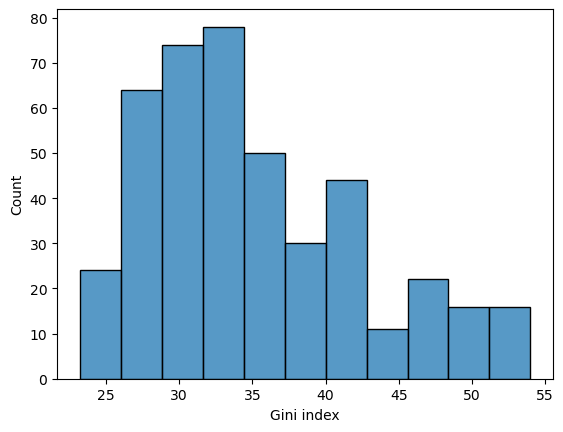

In [52]:
sns.histplot(df['Gini index'])

<Axes: xlabel='Residuals', ylabel='Count'>

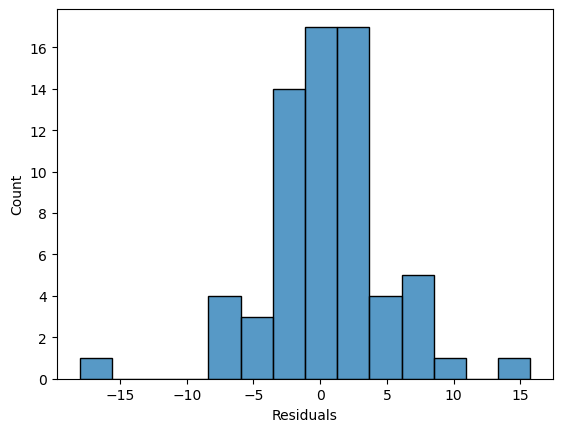

In [40]:
sns.histplot(by_country['Residuals'])